In [ ]:
%%capture
import os
import quaternion
import habitat_sim.sim
import numpy as np
from scipy.io import wavfile


os.chdir(os.environ.get('WORKSPACE_FOLDER', '/sound-spaces'))
dataset = 'mp3d' # or replace with 'mp3d', one example for each dataset

# 1. Create habitat sim object & configuration
backend_cfg = habitat_sim.SimulatorConfiguration()
if dataset == 'mp3d':
    backend_cfg.scene_id = "data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb"
    # IMPORTANT: missing this file will lead to load the semantic scene incorrectly
    backend_cfg.scene_dataset_config_file = "data/scene_datasets/mp3d/mp3d.scene_dataset_config.json"
else:
    backend_cfg.scene_id = "data/scene_datasets/gibson/Oyens.glb"
    # IMPORTANT: missing this file will lead to load the semantic scene incorrectly
    backend_cfg.scene_dataset_config_file = "data/scene_datasets/gibson/gibson_semantic.scene_dataset_config.json"
backend_cfg.load_semantic_mesh = True
backend_cfg.enable_physics = False
agent_config = habitat_sim.AgentConfiguration()
cfg = habitat_sim.Configuration(backend_cfg, [agent_config])
sim = habitat_sim.Simulator(cfg)

# set navmesh path for searching for navigable points
if dataset == 'mp3d':
    sim.pathfinder.load_nav_mesh(os.path.join(f"data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.navmesh"))
else:
    sim.pathfinder.load_nav_mesh(os.path.join(f"data/scene_datasets/gibson/Oyens.navmesh"))

# 2. Create the AudioSensorSpec()
audio_sensor_spec = habitat_sim.AudioSensorSpec()
audio_sensor_spec.uuid = "audio_sensor"
audio_sensor_spec.enableMaterials = True

# 3. Set the acoustic config object (RLRAudioPropagationConfiguration()


# 4. Set the channel layout (RLRAudioPropagationChannelLayout)
audio_sensor_spec.channelLayout.type = habitat_sim.sensor.RLRAudioPropagationChannelLayoutType.Binaural
audio_sensor_spec.channelLayout.channelCount = 1
# audio sensor location set with respect to the agent
audio_sensor_spec.position = [0.0, 1.5, 0.0]  # audio sensor has a height of 1.5m
audio_sensor_spec.acousticsConfig.sampleRate = 48000
# whether indrect (reverberation) is present in the rendered IR
audio_sensor_spec.acousticsConfig.indirect = True

# 5. Add the audio sensor spec to the simulation (creates C++ AudioSensor object)
sim.add_sensor(audio_sensor_spec)


# 6. Get the AudioSensor object from the list of sensors (id is set under AudioSensorSpec -> uuid config)
audio_sensor = sim.get_agent(0)._sensors["audio_sensor"]
audio_sensor.setAudioMaterialsJSON("data/mp3d_material_config.json")

[13:33:50:518959]:[Metadata] AttributesManagerBase.h(380)::createFromJsonOrDefaultInternal : <Dataset>: Proposing JSON name : default.scene_dataset_config.json from original name : default| This file does not exist.
[13:33:50:519009]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DSolid:capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
[13:33:50:519031]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DWireframe:capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
[13:33:50:519046]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneSolid:coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_false_capEnd_true) created and registered.
[13:33:50:519061]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneWireframe:coneWireframe_s

[13:33:50:519675]:[Metadata] SceneDatasetAttributesManager.cpp(308)::readDatasetJSONCell : "stages.default_attributes" set in Attributes Manager from JSON.
[13:33:50:519716]:[Metadata] AttributesManagerBase.h(352)::buildAttrSrcPathsFromJSONAndLoad : Glob path result for data/scene_datasets/mp3d/*/*.glb : data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb
[13:33:50:519799]:[Metadata] SceneInstanceAttributesManager.cpp(65)::setValsFromJSONDoc : No Stage specified for scene default_attributes , or specification error.
[13:33:50:519805]:[Metadata] SceneInstanceAttributesManager.cpp(105)::setValsFromJSONDoc : No Articulated Objects specified for scene default_attributes , or specification error.
[13:33:50:519810]:[Metadata] SceneInstanceAttributesManager.cpp(125)::setValsFromJSONDoc : No navmesh_instance specified for scene default_attributes .
[13:33:50:519815]:[Metadata] SceneInstanceAttributesManager.cpp(135)::setValsFromJSONDoc : No semantic_scene_instance specified for scene default_

es (cylinderWireframe:cylinderWireframe_rings_1_segments_32_halfLen_1) created and registered.
[13:33:50:519487]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (icosphereSolid:icosphereSolid_subdivs_1) created and registered.
[13:33:50:519498]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (icosphereWireframe:icosphereWireframe_subdivs_1) created and registered.
[13:33:50:519511]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (uvSphereSolid:uvSphereSolid_rings_8_segments_16_useTexCoords_false_useTangents_false) created and registered.
[13:33:50:519521]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (uvSphereWireframe:uvSphereWireframe_rings_16_segments_32) created and registered.
[13:33:50:519531]:[Metadata] AssetAttributesManager.cpp(110)::AssetAttributesManager : Built default primitive asset templates : 12
[13:33:50:519727]:[Metadata] AttributesManagerBase.h(265)::load

In [7]:
# sampled navigable point is on the floor
source_pos = sim.pathfinder.get_random_navigable_point()
print('Sample source location: ', source_pos)

Sample source location:  [-4.457195    0.072447   -0.34131554]


In [ ]:
# 7. Set the location of the audio source (setAudioSourceTransform)
audio_sensor.setAudioSourceTransform(source_pos + np.array([0, 1.5, 0])) # add 1.5m to the height calculation 
agent = sim.get_agent(0)
new_state = sim.get_agent(0).get_state()
new_state.position = np.array(source_pos + np.array([2, 0, 0]))
new_state.sensor_states = {}
agent.set_state(new_state, True)

# 8. Run the simulation and get the audio sensor output with the uuid defined
ir = np.array(sim.get_sensor_observations()["audio_sensor"])
print(ir.shape) # (n, d) with n=channel cound as defined in RLRAudioPropagationChannelLayout

# one a category is not found in the material mapping file, the default acoustic material will be used.

(2, 47759)
[13:26:18:123056]:[Sensor] AudioSensor.cpp(86)::setAudioSourceTransform : [Audio]  Setting the audio source position :  Vector(-4.45719, 1.57245, -0.341316) ]
[13:26:18:123108]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
CreateContext: Context created
[13:26:18:123998]:[Sensor] AudioSensor.cpp(104)::setAudioListenerTransform : [Audio]  Setting the agent transform : position [ Vector(-2.45719, 1.57245, -0.341316) ], rotQuat[ Vector(1, 0, 2.45858e-05, 0) ]
[13:26:18:124034]:[Sensor] AudioSensor.cpp(321)::createAudioSimulator : [Audio]  Create audio simulator
[13:26:18:124050]:[Sensor] AudioSensor.cpp(130)::runSimulation : [Audio]  Running the audio simulator
[13:26:18:124059]:[Sensor] AudioSensor.cpp(135)::runSimulation : [Audio]  New initialization, will upload geometry
[13:26:18:124067]:[Sensor] AudioSensor.cpp(139)::runSimulation : [Audio]  Loading semantic scene
[13:26:18:124076]:[Sensor] AudioSensor.cpp(361)::loadSemanticMesh : [A

Material for category 'picture' was not found. Using default material instead.
Material for category 'objects' was not found. Using default material instead.
Material for category 'void' was not found. Using default material instead.
Material for category 'misc' was not found. Using default material instead.


In [13]:
# check if the direct sound is present (source is visibile from the listener)
audio_sensor.sourceIsVisible()

True

In [14]:
# check the efficiency of rendering, outdoor would have a very low value, e.g. < 0.05, 
# while a closed indoor room would have >0.95, and a room with some holes might be in the 0.1-0.8 range.
# if the ray efficiency is low for an indoor environment, it indicates a lot of ray leak from holes
# you should repair the mesh in this case for more accurate acoustic rendering
audio_sensor.getRayEfficiency()

0.5480619668960571

(2, 47759)


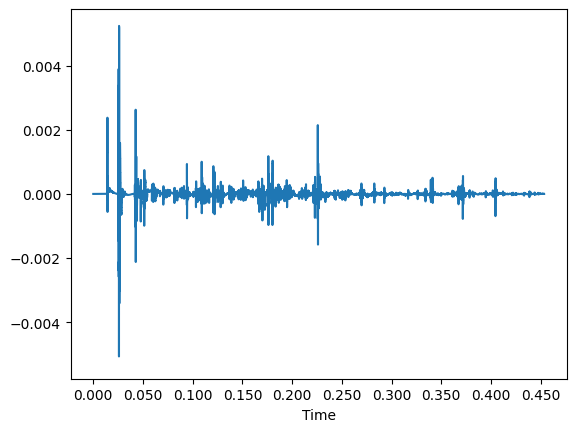

In [17]:
# plot the waveform of IR and show the audio
from librosa.display import waveshow, specshow
import IPython

waveshow(ir[0, :10000])
IPython.display.Audio(ir, rate=48000)

In [18]:
# one example for how to use IR data to get the reverberant speech
sr, vocal = wavfile.read('res/singing.wav')
print(sr, vocal.shape)
IPython.display.Audio(vocal, rate=sr)

48000 (233873,)


/tmp/ipykernel_16232/3675352108.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, vocal = wavfile.read('res/singing.wav')


In [19]:
from scipy.signal import fftconvolve

# convolve the vocal with IR
convolved_vocal = np.array([fftconvolve(vocal, ir_channel) for ir_channel in ir]) 
IPython.display.Audio(convolved_vocal, rate=sr)

In [23]:
# %pip install pyroomacoustics

RT60 of the rendered IR is 0.3719 seconds


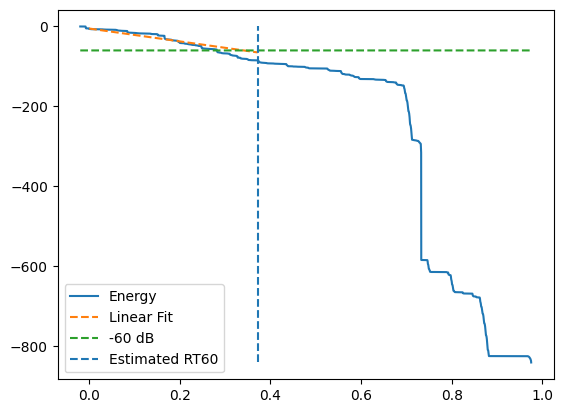

In [22]:
from pyroomacoustics.experimental.rt60 import measure_rt60

rt60 = measure_rt60(ir[0], sr, decay_db=30, plot=True)
print(f'RT60 of the rendered IR is {rt60:.4f} seconds')